In [1]:
import numpy as np
import pandas as pd
import datetime

from datascience import *
from datetime import timedelta
from datetime import date
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import locale

In [2]:
# Import CSV
csv_directory = "data/csv/"

all_sales_data = Table.read_table(csv_directory+'manhattan.csv', low_memory=False)


In [3]:
# remove and sales less than $10,000 they are likely to be a property transfer rather than an actual sale


all_sales_data = all_sales_data.where('SALE PRICE', are.above(10000))

In [4]:
# Declare column names to allow for auto completion :)

COL_SALE_DATE = 'SALE DATE'

In [5]:
# Converr sale date from a string to datetime type

dates = [ datetime.strptime(d, '%Y-%m-%d') for d in all_sales_data.column(COL_SALE_DATE) ]

# Drop string sale date column
all_sales_data = all_sales_data.drop(COL_SALE_DATE)
# Add the sales as type datetime
all_sales_data = all_sales_data.with_column(COL_SALE_DATE, dates)
# Move sale date to the first column
all_sales_data = all_sales_data.move_to_start(COL_SALE_DATE)

all_sales_data

SALE DATE,Unnamed: 0,ADDRESS,APARTMENT NUMBER,BLOCK,BOROUGH,BUILDING CLASS AS OF FINAL ROLL 17/18,BUILDING CLASS AT PRESENT,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,COMMERCIAL UNITS,EASE-MENT,GROSS SQUARE FEET,LAND SQUARE FEET,LOT,NEIGHBORHOOD,RESIDENTIAL UNITS,SALE PRICE,TAX CLASS AS OF FINAL ROLL 17/18,TAX CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,TOTAL UNITS,YEAR BUILT,ZIP CODE
2015-03-18 00:00:00,0,526 EAST 5TH STREET,,400,1,nan,A4,A4,01 ONE FAMILY DWELLINGS,0,,5200,1883,19,ALPHABET CITY,1,6500000,nan,1,1,1,1900,10009
2015-10-22 00:00:00,1,264 EAST 7TH STREET,,376,1,nan,C0,C0,03 THREE FAMILY DWELLINGS,0,,3696,2059,24,ALPHABET CITY,3,3775000,nan,1,1,3,1900,10009
2015-06-24 00:00:00,2,243 EAST 7TH STREET,,377,1,nan,C0,C0,03 THREE FAMILY DWELLINGS,0,,3084,2381,66,ALPHABET CITY,3,2900000,nan,1,1,3,1899,10009
2015-06-15 00:00:00,3,238 EAST 4TH STREET,-,399,1,nan,R6,R6,04 TAX CLASS 1 CONDOS,0,,0,0,1101,ALPHABET CITY,1,6995000,nan,1C,1,1,1955,10009
2015-11-17 00:00:00,4,326 EAST 4TH STREET,,373,1,nan,C1,C1,07 RENTALS - WALKUP APARTMENTS,0,,8625,2204,16,ALPHABET CITY,10,20000000,nan,2B,2,10,1899,10009
2015-02-05 00:00:00,6,102 AVENUE C,,376,1,nan,C4,C4,07 RENTALS - WALKUP APARTMENTS,3,,16679,3772,7,ALPHABET CITY,26,14550000,nan,2,2,29,1900,10009
2015-09-10 00:00:00,8,112 AVENUE C,,377,1,nan,C7,C7,07 RENTALS - WALKUP APARTMENTS,3,,19830,4510,2,ALPHABET CITY,22,16700000,nan,2,2,25,1900,10009
2015-03-11 00:00:00,10,133 AVENUE D,,379,1,nan,C7,C7,07 RENTALS - WALKUP APARTMENTS,2,,14588,3481,37,ALPHABET CITY,20,10500000,nan,2,2,22,1930,10009
2015-01-29 00:00:00,11,250-254 EAST 4TH STREET,,386,1,nan,C4,C4,07 RENTALS - WALKUP APARTMENTS,1,,33130,7191,11,ALPHABET CITY,34,800265,nan,2,2,35,1900,10009
2015-12-09 00:00:00,12,620 EAST 6TH STREET,,387,1,nan,C7,C7,07 RENTALS - WALKUP APARTMENTS,2,,13546,3445,119,ALPHABET CITY,22,11250000,nan,2,2,24,1920,10009


In [6]:
# SPOT CHECK: Understand the data lables we might be interested in
all_sales_data.sort("SALE PRICE").show(20)
all_sales_data.labels

SALE DATE,Unnamed: 0,ADDRESS,APARTMENT NUMBER,BLOCK,BOROUGH,BUILDING CLASS AS OF FINAL ROLL 17/18,BUILDING CLASS AT PRESENT,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,COMMERCIAL UNITS,EASE-MENT,GROSS SQUARE FEET,LAND SQUARE FEET,LOT,NEIGHBORHOOD,RESIDENTIAL UNITS,SALE PRICE,TAX CLASS AS OF FINAL ROLL 17/18,TAX CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,TOTAL UNITS,YEAR BUILT,ZIP CODE
2004-06-02 00:00:00,13333,870 7 AVENUE,1614,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1322,MIDTOWN WEST,0,10007,nan,4,4,1,0,10019
2004-06-18 00:00:00,13428,870 7 AVENUE,1511,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1338,MIDTOWN WEST,0,10007,nan,4,4,1,0,10019
2003-04-21 00:00:00,19770,220,104,1171,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1917,UPPER WEST SIDE (59-79),0,10020,nan,4,4,1,0,10069
2011-06-09 00:00:00,11902,200 WEST 56TH STREET,,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1199,MIDTOWN WEST,0,10035,nan,4,4,1,0,10019
2011-03-03 00:00:00,11956,200 WEST 56TH STREET,,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1208,MIDTOWN WEST,0,10035,nan,4,4,1,0,10019
2011-12-21 00:00:00,12903,870 7 AVENUE,220,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1721,MIDTOWN WEST,0,10035,nan,4,4,1,1925,10019
2011-10-19 00:00:00,12904,870 7 AVENUE,220,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1721,MIDTOWN WEST,0,10035,nan,4,4,1,1925,10019
2011-08-24 00:00:00,12908,870 7 AVENUE,220,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1721,MIDTOWN WEST,0,10035,nan,4,4,1,1925,10019
2011-02-23 00:00:00,12922,870 7 AVENUE,221,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1722,MIDTOWN WEST,0,10035,nan,4,4,1,1925,10019
2011-09-14 00:00:00,12940,870 7 AVENUE,223,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1724,MIDTOWN WEST,0,10035,nan,4,4,1,1925,10019


('SALE DATE',
 'Unnamed: 0',
 'ADDRESS',
 'APARTMENT NUMBER',
 'BLOCK',
 'BOROUGH',
 'BUILDING CLASS AS OF FINAL ROLL 17/18',
 'BUILDING CLASS AT PRESENT',
 'BUILDING CLASS AT TIME OF SALE',
 'BUILDING CLASS CATEGORY',
 'COMMERCIAL UNITS',
 'EASE-MENT',
 'GROSS SQUARE FEET',
 'LAND SQUARE FEET',
 'LOT',
 'NEIGHBORHOOD',
 'RESIDENTIAL UNITS',
 'SALE PRICE',
 'TAX CLASS AS OF FINAL ROLL 17/18',
 'TAX CLASS AT PRESENT',
 'TAX CLASS AT TIME OF SALE',
 'TOTAL UNITS',
 'YEAR BUILT',
 'ZIP CODE')

In [7]:
# Remove columns we don't actually need. e.g. lot, block etc

all_sales_data = all_sales_data.select(['SALE DATE', 'SALE PRICE', 'ADDRESS','APARTMENT NUMBER', 'YEAR BUILT', 'NEIGHBORHOOD', 'ZIP CODE', 'BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY'])

In [8]:
# Combine the Address and Apt No. The data here seems a little funky. Sometime the address itself contains the apt no,
# other times it's seperated. Let's create a full address column that combines them into a single address

def combine_address(address, aptNo):
    """Combine the address and Apartment into a single result"""
    temp = address.strip()
    if len(aptNo.strip()) > 0:
        temp = temp + ', ' + aptNo.strip()
    return temp

full_address = all_sales_data.apply(combine_address, ['ADDRESS', 'APARTMENT NUMBER'])

/usr/local/lib/python3.6/site-packages/datascience/tables.py:361: FutureWarning: column lists are deprecated; pass each as an argument
  "column lists are deprecated; pass each as an argument", FutureWarning)


In [9]:
# Add a Full Address column
all_sales_data =  all_sales_data.with_column('FULL ADDRESS', full_address)

In [10]:
# Try to understand Building Class Codes. What are the most common Codes?

all_sales_data.group(['BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY']).sort('count', descending=True).show(20)

# Question what's R5 -  COMMERCIAL CONDOS? ignoring for now

BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,count
R4,13 CONDOS - ELEVATOR APARTMENTS,90397
D4,10 COOPS - ELEVATOR APARTMENTS,83679
R5,28 COMMERCIAL CONDOS,18200
R4,13 CONDOS - ELEVATOR APARTMENTS,10873
C6,09 COOPS - WALKUP APARTMENTS,10423
D4,10 COOPS - ELEVATOR APARTMENTS,10331
R9,17 CONDOPS,10124
H2,25 LUXURY HOTELS,9785
RH,45 CONDO HOTELS,5478
R9,17 CONDO COOPS,4155


In [11]:
# Let's pick out the condos for now. 
# See ## for condo codes
condos = all_sales_data.where('BUILDING CLASS AT TIME OF SALE', are.contained_in("R1R2R3R4R6"))

In [12]:
# Spot Check condo data
condos.sample(10)

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2008-03-03 00:00:00,609931,421 EAST 13TH STREET,3E,2007,EAST VILLAGE,10009,R4,13 CONDOS - ELEVATOR APARTMENTS,"421 EAST 13TH STREET, 3E"
2008-04-25 00:00:00,541359,315 7TH AVENUE,19C,0,CHELSEA,10001,R4,13 CONDOS - ELEVATOR APARTMENTS,"315 7TH AVENUE, 19C"
2012-11-02 00:00:00,5000000,641 5 AVENUE,38A,0,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"641 5 AVENUE, 38A"
2008-03-27 00:00:00,878668,211 EAST 46TH STREET,25G,1979,MIDTOWN EAST,10017,R4,13 CONDOS - ELEVATOR APARTMENTS,"211 EAST 46TH STREET, 25G"
2011-03-21 00:00:00,977520,18 PINE STREET,1816,1928,FINANCIAL,10005,R4,13 CONDOS - ELEVATOR APARTMENTS,"18 PINE STREET, 1816"
2015-09-01 00:00:00,655500,88 GREENWICH STREET,524,1956,FINANCIAL,10006,R4,13 CONDOS - ELEVATOR APARTMENTS,"88 GREENWICH STREET, 524"
2017-12-19 00:00:00,687500,211 WEST 71ST STREET,7D,1985,UPPER WEST SIDE (59-79),10023,R4,13 CONDOS - ELEVATOR APARTMENTS,"211 WEST 71ST STREET, 7D"
2008-04-07 00:00:00,1007049,555 WEST 59TH STREET,15D,2007,UPPER WEST SIDE (59-79),10019,R4,13 CONDOS - ELEVATOR APARTMENTS,"555 WEST 59TH STREET, 15D"
2009-07-16 00:00:00,1125000,1474 3 AVENUE,3N,0,UPPER EAST SIDE (79-96),10028,R4,13 CONDOS - ELEVATOR APARTMENTS,"1474 3 AVENUE, 3N"
2013-08-05 00:00:00,412500,2056 5 AVENUE,5-C,1920,HARLEM-CENTRAL,10035,R4,13 CONDOS - ELEVATOR APARTMENTS,"2056 5 AVENUE, 5-C"


In [13]:
# Let's find condos with multiple sales

condos.group('FULL ADDRESS').sort(1, descending=True)

# Looks like Apt numbers are missing for most of the top sales. let's ignore anything without an apt number. 

FULL ADDRESS,count
1 WEST END AVENUE,136
45 EAST 22ND STREET,51
245 WEST 99TH STREET,50
171 WEST 131 STREET,44
959 1 AVENUE,42
416 WEST 52ND STREET,39
245 WEST 99TH STREET,37
2094 FREDRICK DOUGLASS BL,35
172 MADISON AVENUE,35
360 EAST 89TH STREET,23


In [14]:
# Find condos with apt numbers i.e. clean data, then find those with more that 1 sale record.

multi_sale_condos = condos.where('FULL ADDRESS', are.containing(',')).group('FULL ADDRESS').sort(1, descending=True).where('count', are.above(1))
multi_sale_condos

#ahh much better, fewer sales but still roughly 15K records enough to proceed

FULL ADDRESS,count
"2 EAST 55 STREET, 835",8
"2 EAST 55TH STREET, 935",7
"2 EAST 55 STREET, 921",7
"140 7 AVENUE, 6A",7
"77 PARK AVENUE, 2F",6
"418 CENTRAL PARK WEST, 22",6
"2 EAST 55 STREET, 936",6
"2 EAST 55 STREET, 903",6
"15 BROAD STREET, 2116",6
"1420 YORK AVENUE, 5M",6


In [15]:
# Define a new table for condos with multiple sales. 

multi_sale_condos = multi_sale_condos.join('FULL ADDRESS', condos, 'FULL ADDRESS')
multi_sale_condos.sort(0)

FULL ADDRESS,count,SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY
"1 BOND STREET, 2B",2,2004-08-04 00:00:00,31000,1 BOND STREET,2B,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2B",2,2009-08-20 00:00:00,1591000,1 BOND STREET,2B,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2C",2,2017-08-18 00:00:00,5640000,1 BOND STREET,2C,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2C",2,2010-12-15 00:00:00,600000,1 BOND STREET,2C,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2D",2,2009-04-24 00:00:00,1195000,1 BOND STREET,2D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2D",2,2014-01-07 00:00:00,1925000,1 BOND STREET,2D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 3A",2,2013-06-14 00:00:00,7200000,1 BOND STREET,3A,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 3A",2,2008-06-06 00:00:00,5030000,1 BOND STREET,3A,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 4D",2,2006-08-30 00:00:00,1565000,1 BOND STREET,4D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 4D",2,2013-08-20 00:00:00,2415000,1 BOND STREET,4D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS


In [16]:
# Find the first and last Sale Dates

first_sale_dates = multi_sale_condos.select(0, 2).group([0], min)
last_sale_dates = multi_sale_condos.select(0, 2).group([0], max)

# Spot check data
first_sale_dates.show(5)
last_sale_dates.show(5)

FULL ADDRESS,SALE DATE min
"1 BOND STREET, 2B",2004-08-04 00:00:00
"1 BOND STREET, 2C",2010-12-15 00:00:00
"1 BOND STREET, 2D",2009-04-24 00:00:00
"1 BOND STREET, 3A",2008-06-06 00:00:00
"1 BOND STREET, 4D",2006-08-30 00:00:00


FULL ADDRESS,SALE DATE max
"1 BOND STREET, 2B",2009-08-20 00:00:00
"1 BOND STREET, 2C",2017-08-18 00:00:00
"1 BOND STREET, 2D",2014-01-07 00:00:00
"1 BOND STREET, 3A",2013-06-14 00:00:00
"1 BOND STREET, 4D",2013-08-20 00:00:00


In [17]:
# Update Labels

first_sale_dates = first_sale_dates.relabel(1, 'FIRST SALE')
last_sale_dates = last_sale_dates.relabel(1, 'LAST SALE')

In [18]:
# Join with Condos to get the sale price
first_sale_dates = first_sale_dates.join("FULL ADDRESS", condos, 'FULL ADDRESS').where('SALE DATE', are.equal_to, 'FIRST SALE')
first_sale_dates = first_sale_dates.select('FULL ADDRESS', 'FIRST SALE', 'SALE PRICE')


last_sale_dates = last_sale_dates.join("FULL ADDRESS", condos, 'FULL ADDRESS').where('SALE DATE', are.equal_to, 'LAST SALE')
last_sale_dates = last_sale_dates.select('FULL ADDRESS', 'LAST SALE', 'SALE PRICE')

In [19]:
first_sale_dates.show(5)
last_sale_dates.show(5)

# Hmm earlier we had 14387 now we have more and they don't match. Could we have duplicates??

FULL ADDRESS,FIRST SALE,SALE PRICE
"1 BOND STREET, 2B",2004-08-04 00:00:00,31000
"1 BOND STREET, 2C",2010-12-15 00:00:00,600000
"1 BOND STREET, 2D",2009-04-24 00:00:00,1195000
"1 BOND STREET, 3A",2008-06-06 00:00:00,5030000
"1 BOND STREET, 4D",2006-08-30 00:00:00,1565000


FULL ADDRESS,LAST SALE,SALE PRICE
"1 BOND STREET, 2B",2009-08-20 00:00:00,1591000
"1 BOND STREET, 2C",2017-08-18 00:00:00,5640000
"1 BOND STREET, 2D",2014-01-07 00:00:00,1925000
"1 BOND STREET, 3A",2013-06-14 00:00:00,7200000
"1 BOND STREET, 4D",2013-08-20 00:00:00,2415000


In [20]:
# Yep duplicate sales on the same day wtf!

first_sale_dates.groups([0,1]).sort(2, descending=True)

FULL ADDRESS,FIRST SALE,count
"30 EAST 37TH STREET, 7H",2017-09-25 00:00:00,4
"225 RECTOR PLACE, 6K",2017-12-15 00:00:00,4
"2 EAST 55 STREET, 921",2006-08-22 00:00:00,4
"201 WEST 17TH STREET, 7A",2014-03-31 00:00:00,3
"131 BANK ST, 4",2004-07-01 00:00:00,3
"99 JOHN STREET, 423",2013-11-21 00:00:00,2
"99 BATTERY PLACE, 20-D",2017-12-15 00:00:00,2
"959 FIRST AVENUE, 16B",2017-11-20 00:00:00,2
"959 1ST AVENUE, 5F",2017-11-07 00:00:00,2
"959 1ST AVENUE, 2B",2017-12-19 00:00:00,2


In [21]:
# Spot check some duplicate addresses to understand what's going on
condos.where('FULL ADDRESS', are.equal_to('2 EAST 55 STREET, 921')).show()
first_sale_dates.where('FULL ADDRESS', are.containing('201 WEST 17TH'))

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2006-10-09 00:00:00,467251,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-10-09 00:00:00,403977,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-09-05 00:00:00,451230,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,486720,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,496860,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,486922,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,412393,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"


FULL ADDRESS,FIRST SALE,SALE PRICE
"201 WEST 17TH STREET, 7A",2014-03-31 00:00:00,999652
"201 WEST 17TH STREET, 7A",2014-03-31 00:00:00,999652
"201 WEST 17TH STREET, 7A",2014-03-31 00:00:00,999652


In [22]:
# ok let's just take the corresponding min and max value to keep moving along

first_sale_dates = first_sale_dates.group([0,1], min)
last_sale_dates = last_sale_dates.group([0,1], max)

In [23]:
# Relabel and join the first and last sale tables to create a new condo sales table

first_sale_dates = first_sale_dates.relabel(2, 'FIRST PRICE')
last_sale_dates = last_sale_dates.relabel(2, 'LAST PRICE')


condo_sales = first_sale_dates.join('FULL ADDRESS', last_sale_dates, 'FULL ADDRESS')
condo_sales

FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE
"1 BOND STREET, 2B",2004-08-04 00:00:00,31000,2009-08-20 00:00:00,1591000
"1 BOND STREET, 2C",2010-12-15 00:00:00,600000,2017-08-18 00:00:00,5640000
"1 BOND STREET, 2D",2009-04-24 00:00:00,1195000,2014-01-07 00:00:00,1925000
"1 BOND STREET, 3A",2008-06-06 00:00:00,5030000,2013-06-14 00:00:00,7200000
"1 BOND STREET, 4D",2006-08-30 00:00:00,1565000,2013-08-20 00:00:00,2415000
"1 BOND STREET, 6A",2012-12-12 00:00:00,3600000,2017-09-06 00:00:00,5250000
"1 BOND STREET, 6B",2004-12-01 00:00:00,2996000,2016-05-20 00:00:00,4350000
"1 CENTRAL PARK SOUTH, 2002",2010-12-01 00:00:00,4600000,2018-06-22 00:00:00,4750000
"1 CENTRAL PARK SOUTH, 503",2012-12-18 00:00:00,7995000,2017-02-24 00:00:00,10150000
"1 CENTRAL PARK WEST, 23B",2008-04-03 00:00:00,5580000,2012-06-28 00:00:00,6200000


In [24]:
# Calculate Price Diffs

price_diffs = condo_sales.column('LAST PRICE') - condo_sales.column('FIRST PRICE')
date_diffs = condo_sales.column('LAST SALE') - condo_sales.column('FIRST SALE')

condo_sales = condo_sales.with_column( "PRICE CHANGE", price_diffs, "PERIOD", date_diffs)
condo_sales.set_format('PRICE CHANGE', NumberFormatter())

FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD
"1 BOND STREET, 2B",2004-08-04 00:00:00,31000,2009-08-20 00:00:00,1591000,"1,560,000","1842 days, 0:00:00"
"1 BOND STREET, 2C",2010-12-15 00:00:00,600000,2017-08-18 00:00:00,5640000,"5,040,000","2438 days, 0:00:00"
"1 BOND STREET, 2D",2009-04-24 00:00:00,1195000,2014-01-07 00:00:00,1925000,"730,000","1719 days, 0:00:00"
"1 BOND STREET, 3A",2008-06-06 00:00:00,5030000,2013-06-14 00:00:00,7200000,"2,170,000","1834 days, 0:00:00"
"1 BOND STREET, 4D",2006-08-30 00:00:00,1565000,2013-08-20 00:00:00,2415000,"850,000","2547 days, 0:00:00"
"1 BOND STREET, 6A",2012-12-12 00:00:00,3600000,2017-09-06 00:00:00,5250000,"1,650,000","1729 days, 0:00:00"
"1 BOND STREET, 6B",2004-12-01 00:00:00,2996000,2016-05-20 00:00:00,4350000,"1,354,000","4188 days, 0:00:00"
"1 CENTRAL PARK SOUTH, 2002",2010-12-01 00:00:00,4600000,2018-06-22 00:00:00,4750000,"150,000","2760 days, 0:00:00"
"1 CENTRAL PARK SOUTH, 503",2012-12-18 00:00:00,7995000,2017-02-24 00:00:00,10150000,"2,155,000","1529 days, 0:00:00"
"1 CENTRAL PARK WEST, 23B",2008-04-03 00:00:00,5580000,2012-06-28 00:00:00,6200000,"620,000","1547 days, 0:00:00"


Avg: 381770.5211887727 
Std: 2508099.3864181554 
Min: -183014844 
Max: 44312249
 5%: -153910 
95%: 1846325
 1%: -1401211 
99%: 5060430


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


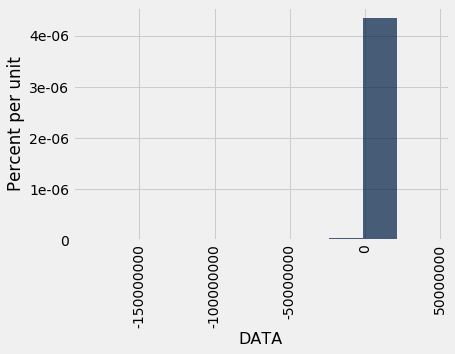

In [25]:
# Understand price difference data
def column_stats( data ):
    '''Prints common stats for a data array'''
    data_mean = np.mean(data)
    data_std = np.std(data)
    data_min = min(data)
    data_max = max(data)

    percent_5 = percentile(5, data)
    percent_95 = percentile(95, data)
    percent_1 = percentile(1, data)
    percent_99 = percentile(99, data)

    print("Avg:", data_mean, "\nStd:", data_std, "\nMin:", data_min, "\nMax:", data_max)
    print(" 5%:", percent_5, "\n95%:", percent_95)
    print(" 1%:", percent_1, "\n99%:", percent_99)

    Table().with_column('DATA', data).hist()

column_stats(price_diffs)



FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD
"15 WILLIAM STREET, 3M",2010-12-01 00:00:00,184414937,2011-12-22 00:00:00,1400093,"-183,014,844","386 days, 0:00:00"
"421 HUDSON STREET, 201",2012-01-18 00:00:00,67602825,2018-04-23 00:00:00,1990000,"-65,612,825","2287 days, 0:00:00"
"322 WEST 57TH STREET, 15B1",2009-08-06 00:00:00,53268315,2011-10-13 00:00:00,1934675,"-51,333,640","798 days, 0:00:00"
"25 MURRAY STREET, LLA",2008-05-07 00:00:00,40000000,2008-08-13 00:00:00,304200,"-39,695,800","98 days, 0:00:00"
"25 MURRAY STREET, 2D",2008-06-17 00:00:00,32800000,2008-07-23 00:00:00,1349181,"-31,450,819","36 days, 0:00:00"
"203 WEST 90 STREET, 7C",2003-01-24 00:00:00,32000000,2003-03-13 00:00:00,648310,"-31,351,690","48 days, 0:00:00"
"220 EAST 65 STREET, 2K",2004-03-11 00:00:00,25750000,2004-05-06 00:00:00,393432,"-25,356,568","56 days, 0:00:00"
"220 EAST 65 STREET, 7D",2004-03-11 00:00:00,25750000,2004-11-08 00:00:00,395460,"-25,354,540","242 days, 0:00:00"
"220 EAST 65 STREET, 3A/B",2004-03-11 00:00:00,25750000,2004-04-15 00:00:00,415740,"-25,334,260","35 days, 0:00:00"
"220 EAST 65 STREET, 2N",2004-03-11 00:00:00,25750000,2004-06-15 00:00:00,420810,"-25,329,190","96 days, 0:00:00"


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


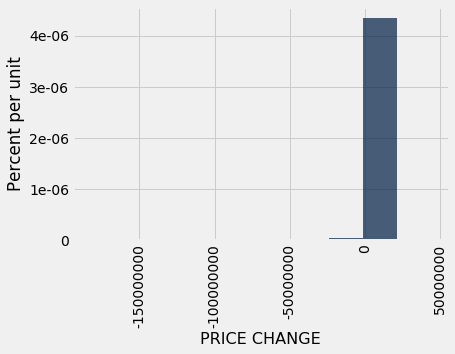

In [26]:
condo_sales.sort('PRICE CHANGE').show(20)

condo_sales.select('PRICE CHANGE').hist()

In [27]:
# strip out the outliers for now. 
percent_1 = percentile(1, price_diffs)
percent_99 = percentile(99, price_diffs)

condo_sales = condo_sales.where('PRICE CHANGE', are.between(percent_1, percent_99))


Avg: 381770.5211887727 
Std: 2508099.3864181554 
Min: -183014844 
Max: 44312249
 5%: -153910 
95%: 1846325
 1%: -1401211 
99%: 5060430
------
Avg: 415531.6870710096 
Std: 666225.3104342404 
Min: -1401211 
Max: 5051231
 5%: -116804 
95%: 1660201
 1%: -560772 
99%: 3408872


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


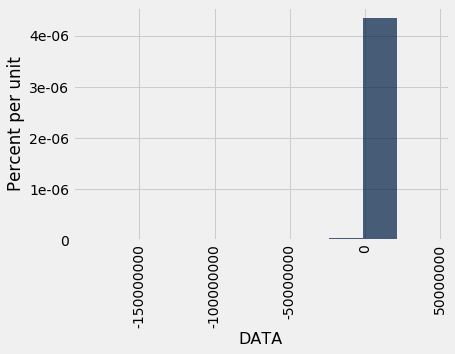

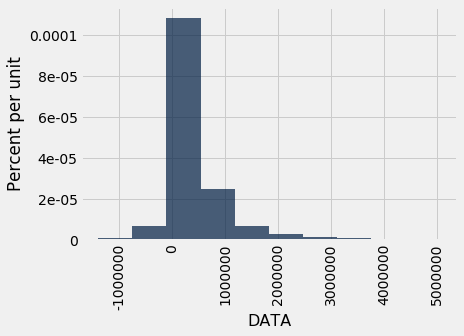

In [28]:
# understand the Price stats with the outliers removed. 

column_stats(price_diffs)

print("------")

column_stats(condo_sales.column('PRICE CHANGE'))

In [29]:
# Some sales are on recorded twice for the same date!
COL_FIRST_SALE_DATE = 'FIRST SALE'
COL_LAST_SALE_DATE = 'LAST SALE'
COL_FIRST_SALE_PRICE = 'FIRST PRICE'
COL_LAST_SALE_PRICE = 'LAST PRICE'
COL_FULL_ADDRESS = 'FULL ADDRESS'
COL_PRICE_CHANGE = 'PRICE CHANGE'
COL_PERIOD = 'PERIOD'

condo_sales.where( COL_FIRST_SALE_DATE, are.equal_to, COL_LAST_SALE_DATE )



FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD
"1 IRVING PLACE, G27B",2017-12-14 00:00:00,1950000,2017-12-14 00:00:00,1950000,0,0:00:00
"1 IRVING PLACE, G9B",2017-12-14 00:00:00,1362500,2017-12-14 00:00:00,1362500,0,0:00:00
"1 MOUNT MORRIS PARK WE, 1C",2017-09-26 00:00:00,1227000,2017-09-26 00:00:00,1227000,0,0:00:00
"1 RIVER TERRACE, 4S",2017-12-06 00:00:00,2790000,2017-12-06 00:00:00,2790000,0,0:00:00
"1 WALL STREET COURT, 201",2017-09-13 00:00:00,1160000,2017-09-13 00:00:00,1160000,0,0:00:00
"10 LITTLE WEST STREET, 24E",2017-11-14 00:00:00,2700000,2017-11-14 00:00:00,2700000,0,0:00:00
"10 MADISON SQUARE WEST, 4F",2017-12-18 00:00:00,6950000,2017-12-18 00:00:00,6950000,0,0:00:00
"100 11TH AVENUE, 12B",2017-12-15 00:00:00,4300000,2017-12-15 00:00:00,4300000,0,0:00:00
"100 CENTRAL PARK SOUTH, 4B",2017-11-14 00:00:00,2350000,2017-11-14 00:00:00,2350000,0,0:00:00
"100 CENTRAL PARK SOUTH, 6A",2017-12-14 00:00:00,2025000,2017-12-14 00:00:00,2025000,0,0:00:00


In [30]:
# Let's spot check these

all_sales_data.where(COL_FULL_ADDRESS, are.equal_to('101 LEONARD STREET, 3D')).sort(0)

# Hmm something strange going no. Let's ignore for now

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2016-02-05 00:00:00,2925000,101 LEONARD STREET,3D,1920,CHINATOWN,10013,R4,13 CONDOS - ELEVATOR APARTMENTS,"101 LEONARD STREET, 3D"
2016-02-05 00:00:00,1812000,101 LEONARD STREET,3D,1920,CHINATOWN,10013,R4,13 CONDOS - ELEVATOR APARTMENTS,"101 LEONARD STREET, 3D"


In [31]:
# Ignore multiple sales on same date

condo_sales = condo_sales.where( COL_FIRST_SALE_DATE, are.not_equal_to, COL_LAST_SALE_DATE )

condo_sales.sort(COL_PERIOD)

# Still Looks like there is some strange data where teh sale dates are a few days apart, 
# for most sales we expect a gap of atleast 60-90 days. 
# let's ignore anything less that 6 months apart i.e. 180 days. 



FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD
"2 EAST 55TH ST, 835",2006-08-15 00:00:00,554946,2006-08-16 00:00:00,486720,"-68,226","1 day, 0:00:00"
"212 EAST 70TH STREET, 2D",2017-03-23 00:00:00,312500,2017-03-24 00:00:00,725000,"412,500","1 day, 0:00:00"
"95 CHARLES STREET, 5",2016-03-25 00:00:00,850000,2016-03-26 00:00:00,850000,0,"1 day, 0:00:00"
"203-05 WEST 112 STREET, 1W",2003-12-17 00:00:00,967338,2003-12-19 00:00:00,967338,0,"2 days, 0:00:00"
"238 EAST 47 STREET, 22D",2004-07-14 00:00:00,105000,2004-07-16 00:00:00,1100000,"995,000","2 days, 0:00:00"
"227 EAST 111 STREET, 5B",2005-03-28 00:00:00,540881,2005-03-31 00:00:00,995000,"454,119","3 days, 0:00:00"
"879-87 8 AVENUE, 2J",2003-11-13 00:00:00,620000,2003-11-16 00:00:00,620000,0,"3 days, 0:00:00"
"157 WEST 111 STREET, 4E",2007-03-09 00:00:00,776925,2007-03-13 00:00:00,834965,"58,040","4 days, 0:00:00"
"500 WEST 43RD STREET, 24F",2014-01-03 00:00:00,800350,2014-01-07 00:00:00,800350,0,"4 days, 0:00:00"
"10 EAST 14TH ST, 2",2007-01-04 00:00:00,1483300,2007-01-09 00:00:00,2698362,"1,215,062","5 days, 0:00:00"


In [32]:
condo_sales.where( COL_PERIOD, are.above(180) )

TypeError: '>' not supported between instances of 'datetime.timedelta' and 'int'

In [ ]:
period_days = [ period.days for period in condo_sales.column(COL_PERIOD)]
column_stats( period_days )


column_stats( condo_sales.column(COL_PRICE_CHANGE) )